In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from collections import Counter

In [2]:
def likelihood(theta, N, K):
    print('Theta:', theta)
    print('N:', N)
    print('K:', K)
    result = 1
    for k in range(K):
        if N[k]:
            result *= theta[k] ** N[k]
    return result
    
def prior(theta, K, concentration):
    result = 1
    for k in range(K):
        result *= theta[k] ** (concentration[k]-1)
    return result

def posterior(theta, N, K, concentration):
    result = 1
    for k in range(K):
        result *= theta[k] ** (concentration[k] + N[k] - 1)
    return result
    
def count_likelihood(domain):
    counter = Counter(domain)
    return counter

Theta: [6.28655924e-01 1.40452508e-02 2.13126171e-01 2.73113577e-02
 7.23502010e-09 1.16861289e-01]
N: Counter({3: 3, 2: 2, 1: 2, 4: 2, 5: 1})
K: 2


<Container object of 6 artists>

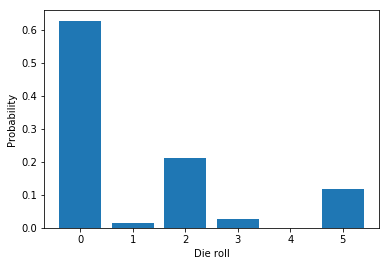

In [3]:
K = 2
N = 10
theta = np.random.dirichlet([np.random.random()] * 6)
domain = []
for _ in range(N):
    domain.append(np.random.randint(1,6))
likelihood_map = count_likelihood(domain)
concentration_parameter = []
for _ in range(N):
    concentration_parameter.append(np.random.randint(1,20))
likelihood_result = likelihood(theta, likelihood_map, K)
prior_result = prior(theta, K, concentration_parameter)
posterior_result = posterior(theta, likelihood_map, K, concentration_parameter)

plt.xlabel('Die roll')
plt.ylabel('Probability')
plt.bar(range(6), theta)

In [4]:
posterior_result

3.627481105952275e-18

In [5]:
def posterior_predictive(concentration, N, j):
    denominator = 0
    for k in range(K):
        denominator += concentration[k] + N[k]
    numerator = concentration[j] + N[j]
    return numerator / denominator

In [6]:
posterior_predictive(concentration_parameter, likelihood_map, 2)

0.2608695652173913

In [7]:
import spacy
nlp = spacy.load('en')

doc = nlp(u"Apples and oranges are similar. Boots and hippos aren't.")

for token in doc:
    print(token, token.lemma, token.lemma_)

Apples 8566208034543834098 apple
and 2283656566040971221 and
oranges 2208928596161743350 orange
are 10382539506755952630 be
similar 18166476740537071113 similar
. 12646065887601541794 .
Boots 9918665227421442029 boot
and 2283656566040971221 and
hippos 6542994350242320795 hippo
are 10382539506755952630 be
n't 447765159362469301 not
. 12646065887601541794 .


In [8]:
words = []
for token in doc:
    words.append(token.lemma_)
word_counter = Counter(words)
words_count = {}
i = 0
for x,y in word_counter.items():
    words_count[i] = (x,y)
    i += 1
print(words_count)

{0: ('apple', 1), 1: ('and', 2), 2: ('orange', 1), 3: ('be', 2), 4: ('similar', 1), 5: ('.', 2), 6: ('boot', 1), 7: ('hippo', 1), 8: ('not', 1)}


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
 
corpus = [
'All my cats in a row',
'When my cat sits down, she looks like a Furby toy!',
'The cat from outer space',
'Sunshine loves to sit like this for some reason.'
]

new_doc = []
for sentence in corpus:
    temp_doc = nlp(sentence)
    temp_sentence = ''
    not_new_sentence = False
    for token in temp_doc:
        if token.lemma_ != '-PRON-':
            if not_new_sentence:
                temp_sentence += ' '
            temp_sentence += token.lemma_
            not_new_sentence = True
        
    new_doc.append(temp_sentence)
print(new_doc)

vectorizer = CountVectorizer()
print( vectorizer.fit_transform(new_doc).todense() )
print( vectorizer.vocabulary_ )

['all cat in a row', 'when cat sit down , look like a furby toy !', 'the cat from outer space', 'sunshine love to sit like this for some reason .']
[[1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0]]
{'all': 0, 'cat': 1, 'in': 6, 'row': 12, 'when': 21, 'sit': 13, 'down': 2, 'look': 8, 'like': 7, 'furby': 5, 'toy': 20, 'the': 17, 'from': 4, 'outer': 10, 'space': 15, 'sunshine': 16, 'love': 9, 'to': 19, 'this': 18, 'for': 3, 'some': 14, 'reason': 11}


### Visualize Dirichlet

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math
from functools import reduce

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

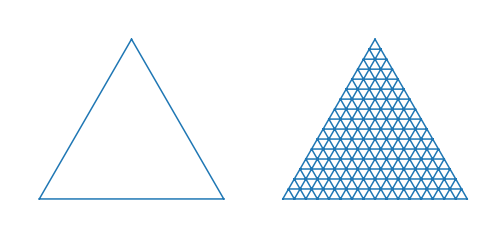

In [11]:
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

In [12]:
# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

In [13]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

In [14]:
def draw_pdf(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

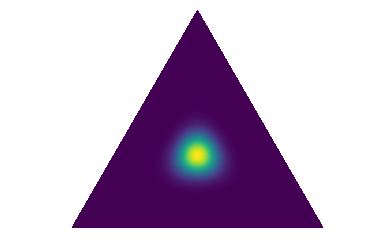

In [15]:
draw_pdf(Dirichlet([20, 20, 20]))

[1, 10, 3, 2, 3, 2, 3, 2, 1, 10, 3, 2, 10, 5, 10, 6, 8]
{1: 2, 10: 4, 3: 4, 2: 4, 5: 1, 6: 1, 8: 1}
{'mary': 2, 'unk': 4, 'little': 4, 'lamb': 4, 'fleece': 1, 'white': 1, 'snow': 1}
Posterior: [0.1111111111111111, 0.18518518518518517, 0.18518518518518517, 0.037037037037037035, 0.07407407407407407, 0.07407407407407407, 0.037037037037037035, 0.07407407407407407, 0.037037037037037035, 0.18518518518518517]

Highest probability: 0.19% of word 'unk'


Text(0.5,0,'Indexes')

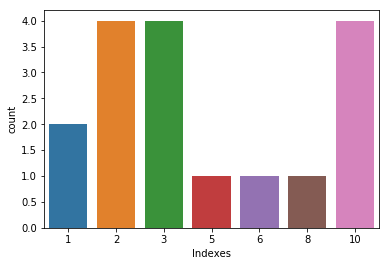

In [124]:
import seaborn as sns
#sentence = 'Mary had a little lamb, little lamb, little lamb, Mary had a little lamb, its fleece as white as snow'
#sequence = sentence.split(' ')
stemmed_sentence = 'mary had little lamb little lamb little lamb mary had little lamb it fleece as white snow'
stemmed_sequence = stemmed_sentence.split(' ')
#mary lamb little big fleece white black snow rain unk
#1 2 3 4 5 6 7 8 9 10
word_dict = {'mary': 1, 'lamb': 2, 'little': 3, 'big': 4, 'fleece': 5, 'white': 6, 'black': 7, 'snow': 8, 'rain': 9, 'unk': 10}

def create_index_vector(sequence, word_dictionary):
    vector = []
    for word in sequence:
        index = word_dictionary.get(word)
        if index is None:
            vector.append(word_dictionary.get('unk'))
        else:
            vector.append(index)
    return vector

def count_occurences(index_vector):
    index_count_dict = {}
    for index in index_vector:
        if not index in index_count_dict:
            index_count_dict[index] = 1
        else:
            index_count_dict[index] += 1
    return index_count_dict
    
def index_meanings(index_occurences, word_dict):
    word_occurences = {}
    for index in index_occurences:
        for key, val in word_dict.items():
            if val == index:
                word = key
        word_occurences[word] = index_occurences[index]
    return word_occurences
        
def posterior_predictive_bag_of_words(sentence, word_dict, alpha=1.0):
    sequence = sentence.split(' ')
    index_vector = create_index_vector(sequence, word_dict)
    index_occurences = count_occurences(index_vector)

    words_len = len(index_vector)
    language_len = len(word_dict)
    
    posterior = []
    for index in word_dict.values():
        if index in index_occurences:
            count = index_occurences[index]
        else:
            count = 0
        res = (1 + count) / (words_len + language_len)
        posterior.append(res)
    return posterior
    
def max_probability(prob_dict):
    max_prob = 0
    max_prob_index = 0
    current_index = 1
    for value in prob_dict:
        if value >= max_prob:
            max_prob_index = current_index
            max_prob = value
        current_index += 1
    return max_prob, max_prob_index
    
def get_word_from_index(word_dict, index):
    word = ''
    for key,val in word_dict.items():
        if index == val:
            word = key
    return word

index_vector = create_index_vector(sequence=stemmed_sequence, word_dictionary=word_dict)
print(index_vector)
index_occurences = count_occurences(index_vector=index_vector)
print(index_occurences)
word_occurences = index_meanings(index_occurences, word_dict)
print(word_occurences)

posterior = posterior_predictive_bag_of_words(stemmed_sentence, word_dict)
print('Posterior:', posterior)
max_prob, max_prob_index = max_probability(posterior) 
print('\nHighest probability: %.2f%% of word \'%s\'' % (max_prob, get_word_from_index(word_dict, max_prob_index)))

fig = sns.countplot(index_vector)
plt.xlabel('Indexes')

### Bag of words

In [30]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)

In [17]:
twenty_train.target_names #prints all the categories
print("\n".join(twenty_train.data[0].split("\n")[:])) #prints first line of the first data file

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(11314, 130107)

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

In [20]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [21]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [22]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.7738980350504514

### Bag of words class prediction

In [23]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)
twenty_train.target_names
print("\n".join(twenty_train.data[0].split("\n")[:3]))
print(twenty_train.target_names[twenty_train.target[0]])
twenty_train.target[:10]
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
comp.graphics
comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2257, 35788)

#### Term Frequency times Inverse Document Frequency

In [26]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 35788)

In [27]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [28]:
docs_new = ['Oh lawd sweet Jesus it\'s a fire', 'Your graphics card supports current settings at 0 fps']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

"Oh lawd sweet Jesus it's a fire" => soc.religion.christian
'Your graphics card supports current settings at 0 fps' => comp.graphics


In [29]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf.fit(twenty_train.data, twenty_train.target)
import numpy as np
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target) 

0.8348868175765646